In [191]:
import numpy  as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import read_quote      as rq
import stock_functions as sf
import df_visualizations as dv
import remap_values as rv
import fill_values as fv

import random
import pickle

import sys
import time

In [2]:
from sklearn.svm            import SVR
from sklearn.ensemble       import RandomForestRegressor
from sklearn.linear_model   import ElasticNet
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble       import BaggingRegressor
from sklearn.ensemble       import AdaBoostRegressor

from sklearn.multioutput    import MultiOutputRegressor

from sklearn.utils          import shuffle

from sklearn.metrics        import mean_squared_error

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.multioutput    import MultiOutputRegressor

In [3]:
%matplotlib inline
plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (14, 10)

In [4]:
roll_nums = [3,5,8,10,15,20,25,30]  # Generate an algorithm for predicting every few days
mom_nums  = [3,5,8,10,15,20,25,30]  # Momentum has many good tracers
rsi_nums  = [10,15,20,25,30]        # Good for some long term trends
band_nums = [5,8,10,15,20,25]       # A few trace different areas well

In [5]:
inpFileList = ['aapl','acm' ,'awk' ,'amzn','awr' ,'ba'  ,'bac' ,'c'   ,'cat' ,'cop' ,'cvx' ,'dal' ,
               'dd'  ,'farm','fdp' ,'gnc' ,'hes' ,'ibm' ,'mas' ,'mcd' ,'mon' ,'msex','msft','nflx',
               'sbux','strl','tgt' ,'tsla','ups' ,'xom' ,'xpo' ,'vmc' ]

In [6]:
scaled_df = sf.get_scaled_data( inpFileList, roll_nums, mom_nums, rsi_nums, band_nums )

In [6]:
#scaled_df = sf.gen_pca_attributes( scaled_df, mom_nums, rsi_nums, band_nums, n_mom=3, n_rsi=2, n_ban=2 )

In [7]:
# Read in each stock, and perform reduction
#    Break into train, test sets
#    Store train, test sets in arrays
# For each regressor predicting a certain num of days...
#    Manually cross validate, testing and scoring each set

In [7]:
# Mix up the list
shuff_scaled_df = shuffle( scaled_df )


# Seperate features from target data
close_list = ['close']
for i in roll_nums:
    close_list.append( 'close_mean_'+str(i) )

targets  = shuff_scaled_df[close_list]
features = shuff_scaled_df.drop( close_list, axis=1 )



n_elements = shuff_scaled_df.shape[0]

# Set the fraction of data we will train over
percent_train = 0.8

# Size of training set
n_train = int( percent_train * n_elements )


# Seperate training and test data
train_features = features[ : n_train   ]
test_features  = features[   n_train : ]

train_targets  =  targets[ : n_train   ].drop( 'close', axis=1 )
test_targets   =  targets[   n_train : ].drop( 'close', axis=1 )

In [8]:
# Gets the location of not null values
train_not_null_locations = train_targets.notnull().all( axis=1 )==1
test_not_null_locations  =  test_targets.notnull().all( axis=1 )==1

# Take features and targets that are not null
train_x = train_features[ train_not_null_locations ].values
test_x  =  test_features[  test_not_null_locations ].values

train_y = train_targets[ train_not_null_locations ].values
test_y  =  test_targets[  test_not_null_locations ].values

ad_mult_reg = MultiOutputRegressor( AdaBoostRegressor( base_estimator=RandomForestRegressor( n_estimators=20, max_features=0.7 ), 
#                            loss='exponential', n_estimators=10 ) )
                            loss='exponential', n_estimators=5 ) )
#                            loss='exponential', n_estimators=3 ) )

ad_mult_reg.fit( train_x, train_y )

MultiOutputRegressor(estimator=AdaBoostRegressor(base_estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.7, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
         learning_rate=1.0, loss='exponential', n_estimators=5,
         random_state=None),
           n_jobs=1)

In [9]:
test_60 = ad_mult_reg.predict( test_x )

for i in range( 1, len( close_list[1:] ) ) :
    mse = mean_squared_error( test_y[i-1], test_60[i-1] )
    print '%13s MSE : %8.5f, Percent ME : %8.5f' % ( close_list[i], mse, np.sqrt(mse)/np.mean(test_y) )

 close_mean_3 MSE :  0.28736, Percent ME : 36.03992
 close_mean_5 MSE :  0.01817, Percent ME :  9.06243
 close_mean_7 MSE :  0.02099, Percent ME :  9.73959
close_mean_10 MSE :  0.00909, Percent ME :  6.41166
close_mean_12 MSE :  0.02232, Percent ME : 10.04452
close_mean_15 MSE :  0.02216, Percent ME : 10.00922


In [29]:
test_70 = ad_mult_reg.predict( test_x )

for i in range( 1, len( close_list[1:] ) ) :
    mse = mean_squared_error( test_y[i-1], test_70[i-1] )
    print '%13s MSE : %8.5f, Percent ME : %8.5f' % ( close_list[i], mse, np.sqrt(mse)/np.mean(test_y) )

 close_mean_3 MSE :  0.11175, Percent ME : 22.26275
 close_mean_5 MSE :  0.02046, Percent ME :  9.52490
 close_mean_7 MSE :  0.01597, Percent ME :  8.41539
close_mean_10 MSE :  0.00119, Percent ME :  2.29876
close_mean_12 MSE :  0.23849, Percent ME : 32.52288
close_mean_15 MSE :  0.26986, Percent ME : 34.59590


In [12]:
test_80 = ad_mult_reg.predict( test_x )

for i in range( 1, len( close_list[1:] )+1 ) :
    mse = mean_squared_error( test_y[i-1], test_80[i-1] )
    print '%13s MSE : %8.5f, Percent ME : %8.5f' % ( close_list[i], mse, np.sqrt(mse)/np.mean(test_y) )

 close_mean_3 MSE :  0.00034, Percent ME :  1.28400
 close_mean_5 MSE :  0.00052, Percent ME :  1.57940
 close_mean_7 MSE :  0.00769, Percent ME :  6.09548
close_mean_10 MSE :  0.00520, Percent ME :  5.01383
close_mean_12 MSE :  0.04772, Percent ME : 15.18780
close_mean_15 MSE :  0.01710, Percent ME :  9.09208
close_mean_20 MSE :  0.04250, Percent ME : 14.33349
close_mean_25 MSE :  0.10339, Percent ME : 22.35573


In [8]:
test_80_5 = ad_mult_reg.predict( test_x )

for i in range( 1, len( close_list[1:] )+1 ) :
    mse = mean_squared_error( test_y[i-1], test_80_5[i-1] )
    print '%13s MSE : %8.5f, Percent ME : %8.5f' % ( close_list[i], mse, np.sqrt(mse)/np.mean(test_y) )

 close_mean_3 MSE :  0.00052, Percent ME :  1.58310
 close_mean_5 MSE :  0.01097, Percent ME :  7.28296
 close_mean_7 MSE :  0.02160, Percent ME : 10.21904
close_mean_10 MSE :  0.00542, Percent ME :  5.11623
close_mean_12 MSE :  0.04154, Percent ME : 14.17041
close_mean_15 MSE :  0.01140, Percent ME :  7.42228
close_mean_20 MSE :  0.01214, Percent ME :  7.66086
close_mean_25 MSE :  0.06858, Percent ME : 18.20686


In [8]:
test_all = ad_mult_reg.predict( test_x )

for i in range( 1, len( close_list[1:] )+1 ) :
    mse = mean_squared_error( test_y[i-1], test_all[i-1] )
    print '%13s MSE : %8.5f, Percent ME : %8.5f' % ( close_list[i], mse, np.sqrt(mse)/np.mean(test_y) )

 close_mean_3 MSE :  0.04622, Percent ME : 16.03829
 close_mean_5 MSE :  0.00280, Percent ME :  3.95061
 close_mean_7 MSE :  0.06953, Percent ME : 19.67037
close_mean_10 MSE :  0.03379, Percent ME : 13.71227
close_mean_12 MSE :  0.00471, Percent ME :  5.11735
close_mean_15 MSE :  0.26712, Percent ME : 38.55589
close_mean_18 MSE :  0.02227, Percent ME : 11.13333
close_mean_20 MSE :  0.00127, Percent ME :  2.66170
close_mean_23 MSE :  0.00853, Percent ME :  6.89029
close_mean_25 MSE :  0.02849, Percent ME : 12.59120
close_mean_28 MSE :  0.00738, Percent ME :  6.40677
close_mean_30 MSE :  0.02438, Percent ME : 11.64905


In [8]:
test_80_3_all = ad_mult_reg.predict( test_x )

for i in range( 1, len( close_list[1:] )+1 ) :
    mse = mean_squared_error( test_y[i-1], test_80_3_all[i-1] )
    print '%13s MSE : %8.5f, Percent ME : %8.5f' % ( close_list[i], mse, np.sqrt(mse)/np.mean(test_y) )

 close_mean_3 MSE :  0.01164, Percent ME :  8.63749
 close_mean_5 MSE :  0.00212, Percent ME :  3.68463
 close_mean_7 MSE :  0.08406, Percent ME : 23.21046
close_mean_10 MSE :  0.00056, Percent ME :  1.89508
close_mean_12 MSE :  0.00012, Percent ME :  0.86886
close_mean_15 MSE :  0.00403, Percent ME :  5.08291
close_mean_18 MSE :  0.01355, Percent ME :  9.31947
close_mean_20 MSE :  0.04023, Percent ME : 16.05616
close_mean_23 MSE :  0.00035, Percent ME :  1.48873
close_mean_25 MSE :  0.00362, Percent ME :  4.81892
close_mean_28 MSE :  0.08284, Percent ME : 23.04127
close_mean_30 MSE :  0.00043, Percent ME :  1.66966


In [9]:
test_80_3_most = ad_mult_reg.predict( test_x )

for i in range( 1, len( close_list[1:] )+1 ) :
    mse = mean_squared_error( test_y[i-1], test_80_3_most[i-1] )
    print '%13s MSE : %8.5f, Percent ME : %8.5f' % ( close_list[i], mse, np.sqrt(mse)/np.mean(abs(test_y) ) )

 close_mean_3 MSE :  0.00222, Percent ME :  0.42910
 close_mean_5 MSE :  0.01836, Percent ME :  1.23313
 close_mean_8 MSE :  0.01501, Percent ME :  1.11468
close_mean_10 MSE :  0.01245, Percent ME :  1.01514
close_mean_15 MSE :  0.00850, Percent ME :  0.83905
close_mean_20 MSE :  0.01199, Percent ME :  0.99655
close_mean_25 MSE :  0.00141, Percent ME :  0.34111
close_mean_30 MSE :  0.00918, Percent ME :  0.87200


In [9]:
test_80_5_most = ad_mult_reg.predict( test_x )

for i in range( 1, len( close_list[1:] )+1 ) :
    mse = mean_squared_error( test_y[i-1], test_80_5_most[i-1] )
    print '%13s MSE : %8.5f, Percent ME : %8.5f' % ( close_list[i], mse, np.sqrt(mse)/np.mean(test_y) )

 close_mean_3 MSE :  0.00385, Percent ME :  9.99972
 close_mean_5 MSE :  0.00011, Percent ME :  1.69317
 close_mean_8 MSE :  0.02368, Percent ME : 24.80523
close_mean_10 MSE :  0.00171, Percent ME :  6.66250
close_mean_15 MSE :  0.00008, Percent ME :  1.46269
close_mean_20 MSE :  0.00089, Percent ME :  4.81670
close_mean_25 MSE :  0.00033, Percent ME :  2.94020
close_mean_30 MSE :  0.00023, Percent ME :  2.41817


In [10]:
pred_values = test_80_5_most

std_dict = {}

for i in range( 0, len( close_list[1:] ) ) :
    rmse = np.sqrt( mean_squared_error( test_y[i], pred_values[i] ) )
    col  = 'std_' + str( roll_nums[i] )
    std_dict[col] = rmse
    print '%13s   RMSE : %8.5f,   RMSE/mean : %8.5f' % ( close_list[i+1], rmse, rmse/np.mean( abs(test_y)) )
    
print std_dict

 close_mean_3   RMSE :  0.06204,   RMSE/mean :  1.33976
 close_mean_5   RMSE :  0.01050,   RMSE/mean :  0.22685
 close_mean_8   RMSE :  0.15389,   RMSE/mean :  3.32340
close_mean_10   RMSE :  0.04133,   RMSE/mean :  0.89264
close_mean_15   RMSE :  0.00907,   RMSE/mean :  0.19597
close_mean_20   RMSE :  0.02988,   RMSE/mean :  0.64534
close_mean_25   RMSE :  0.01824,   RMSE/mean :  0.39393
close_mean_30   RMSE :  0.01500,   RMSE/mean :  0.32399
{'std_25': 0.018240264159727265, 'std_30': 0.015001722433243388, 'std_20': 0.029881622922671106, 'std_15': 0.0090741700991440674, 'std_10': 0.041332526285400115, 'std_5': 0.010504012864607648, 'std_3': 0.062035796486686258, 'std_8': 0.15388549520813605}


In [296]:
quote_name = 'aapl'


# Generate df with the actual rolling averages
close_df = rq.readQuote( 'quotes/'+ quote_name +'.csv' )
close_df = pd.merge( close_df['close'].to_frame(), sf.generate_rolling_close( close_df, roll_nums, onlyMean=True ), left_index=True, right_index=True )
close_means = close_df.columns.values


# Generate predicted rolling mean percentage increases
pred_df     = sf.get_scaled_data( [quote_name], roll_nums, mom_nums, rsi_nums, band_nums ).dropna()
pred_values = ad_mult_reg.predict( pred_df.drop( close_means, axis=1 ) )


# Adjust close to match pred df shape
close_df = close_df.ix[ pred_df.index.values ].dropna()

# Pred percent increase = future/now - 1
for i in range( 0 , pred_values.shape[1] ):
    close_df[ 'pred_mean_' + str( roll_nums[i] ) ] = ( pred_values[:,i] + 1 ) * close_df[ 'close_mean_' + str( roll_nums[i] ) ]
    close_df[ 'pred_mean_' + str( roll_nums[i] ) ] = close_df[ 'pred_mean_' + str( roll_nums[i] ) ].shift( -roll_nums[i]+1 )
#    close_df[ 'pred_mean_' + str( roll_nums[i] ) ] = ( close_df[ 'pred_mean_' + str( roll_nums[i] ) ] + 
#                                                       close_df[ 'pred_mean_' + str( roll_nums[i] ) ].shift(-1) ) / 2.
close_df = close_df.dropna()

In [297]:
smooth_vals = [0,0,3,3,4,5,6,7]
shift_vals  = [0,0,3,3,4,5,6,7]


# Tweak the difference in rolling means per day
# Lots of noise, this may force less noise, might not. We will see
for i in range( 0, len(roll_nums) ):
    
    roll = str( roll_nums[i] )
    if ( smooth_vals[i] > 1 ):
        close_df['pred_mean_'+roll] = close_df['pred_mean_'+roll].values[::-1]
        close_df['pred_mean_'+roll] = close_df['pred_mean_'+roll].rolling(smooth_vals[i]).mean()
        close_df['pred_mean_'+roll] = close_df['pred_mean_'+roll].shift(-shift_vals[i])
        close_df['pred_mean_'+roll] = close_df['pred_mean_'+roll].values[::-1]
#        close_df['new_mean_'+roll] = close_df['pred_mean_'+roll].values[::-1]
#        close_df['new_mean_'+roll] = close_df[ 'new_mean_'+roll].rolling(smooth_vals[i]).mean()
#        close_df['new_mean_'+roll] = close_df[ 'new_mean_'+roll].shift(-shift_vals[i])
#        close_df['new_mean_'+roll] = close_df[ 'new_mean_'+roll].values[::-1]
    else:
#        close_df['new_mean_'+roll] = close_df['pred_mean_'+roll]
        close_df['pred_mean_'+roll] = close_df['pred_mean_'+roll]

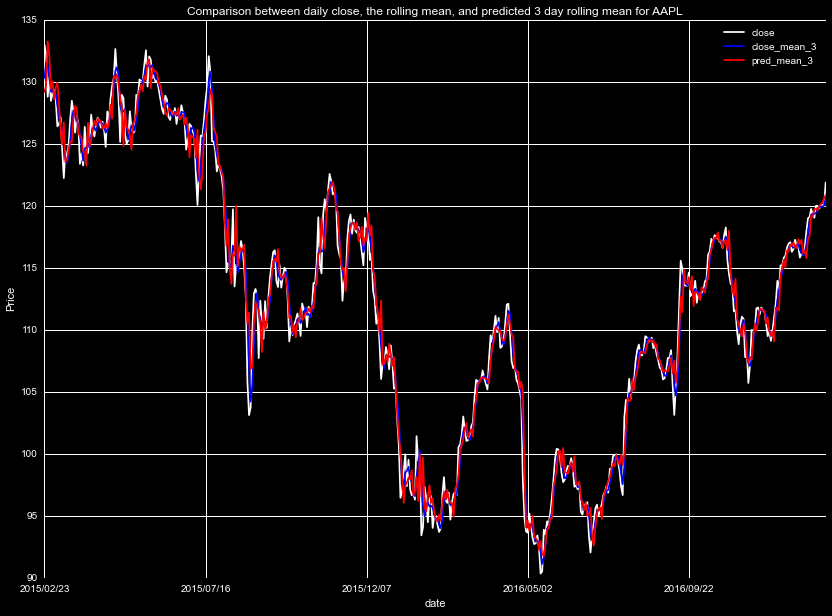

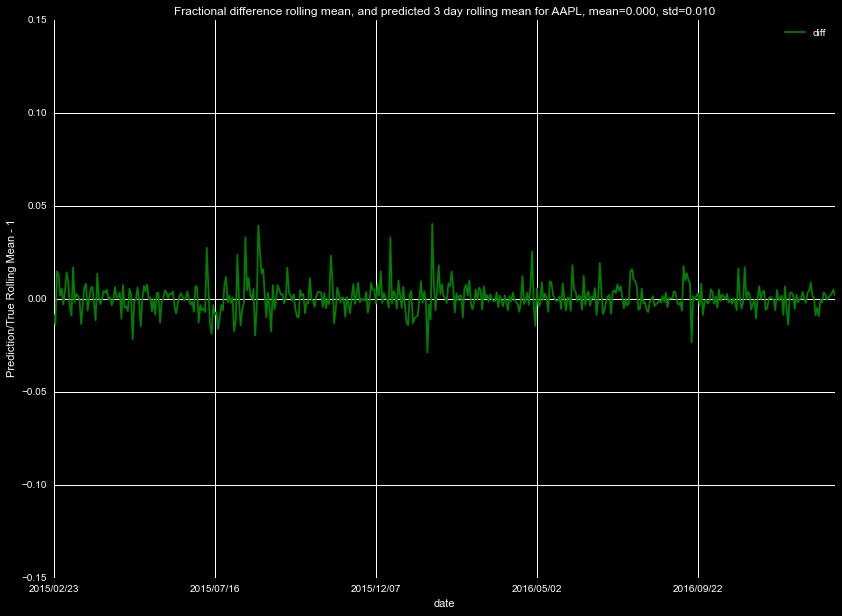

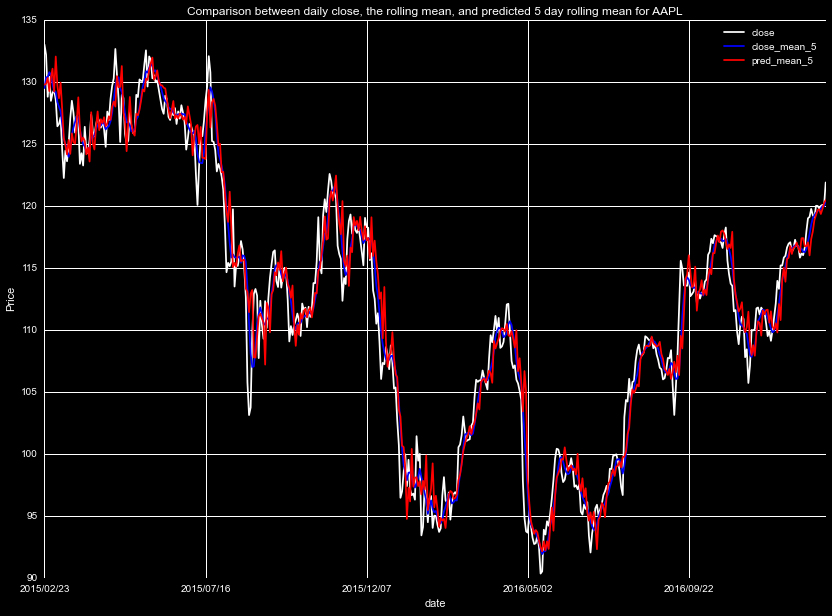

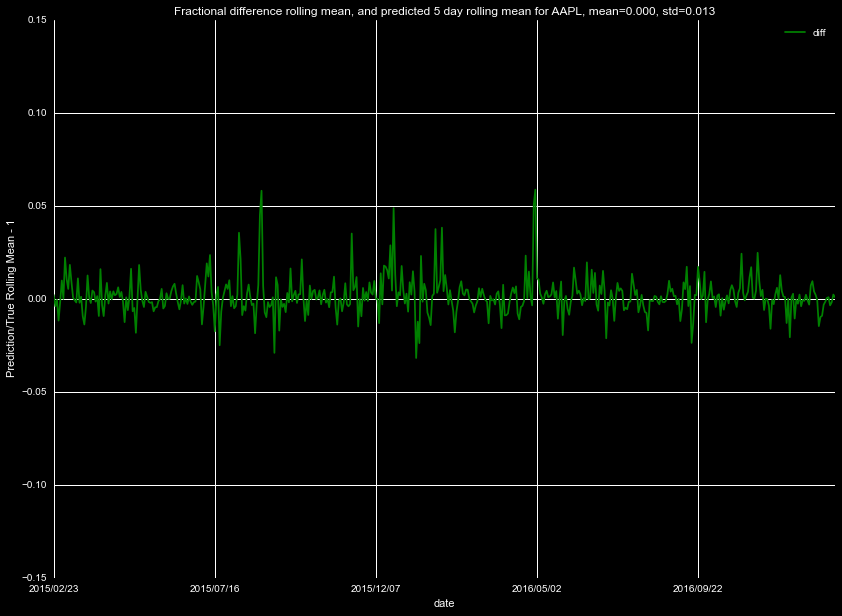

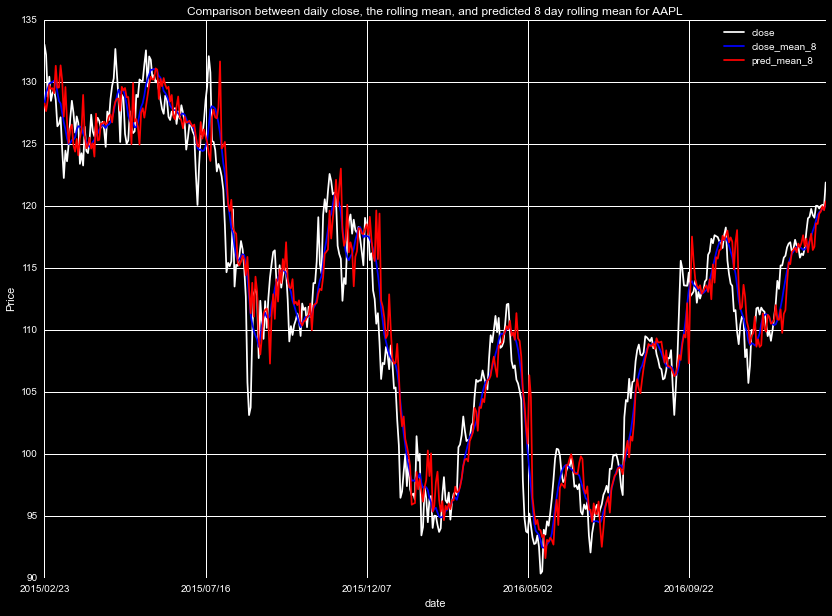

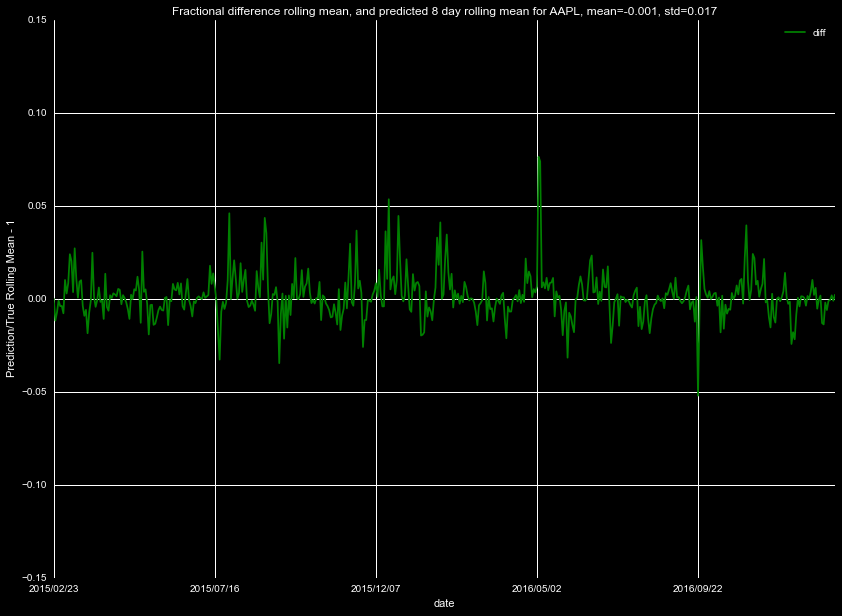

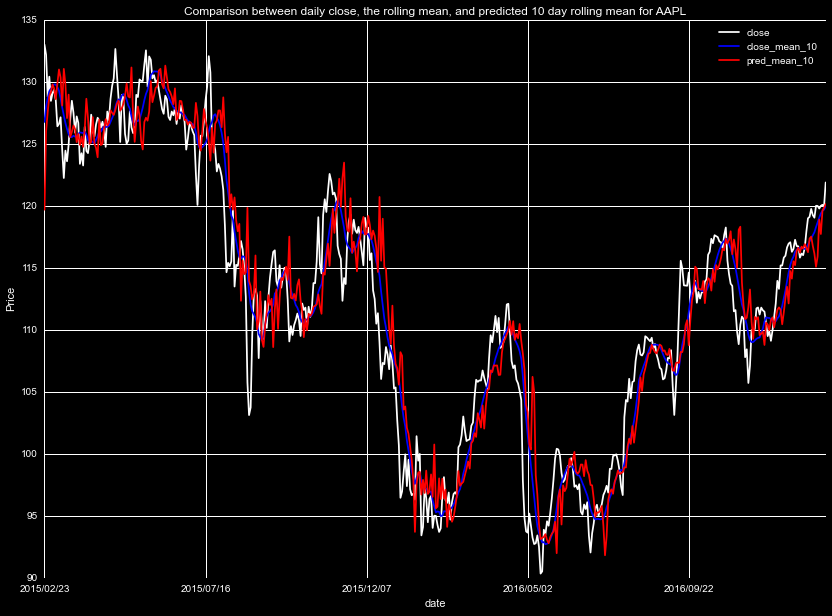

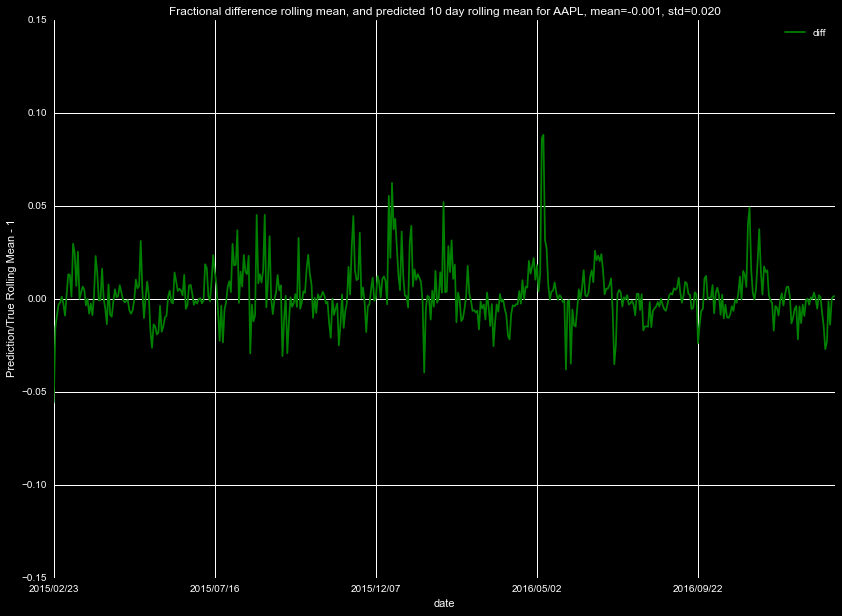

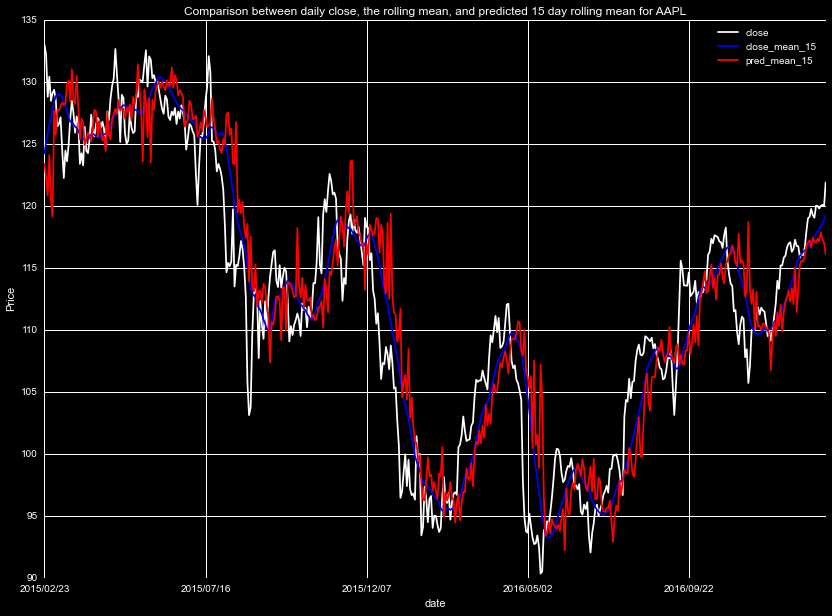

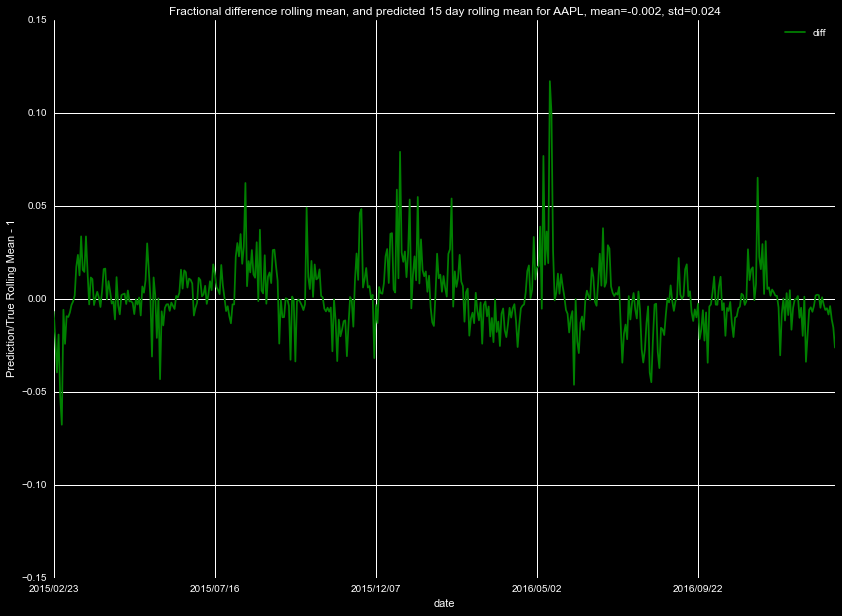

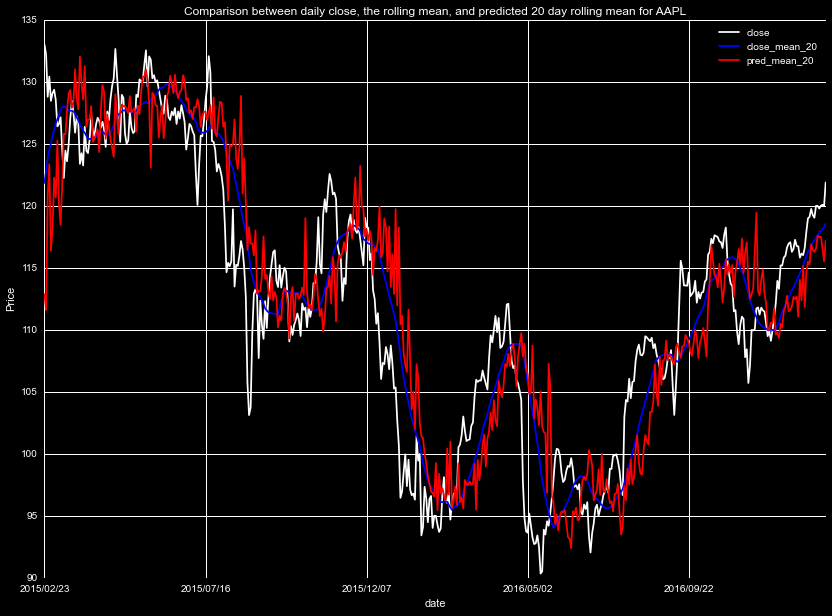

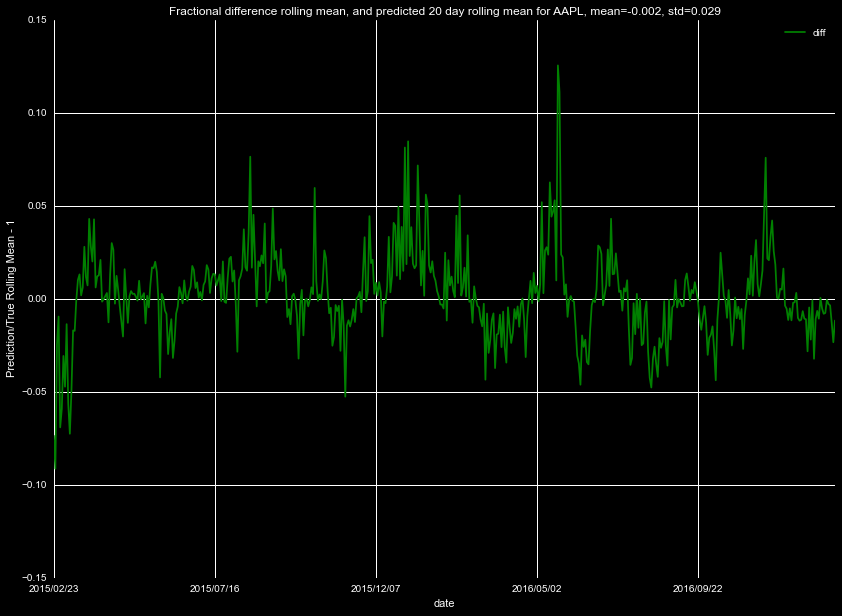

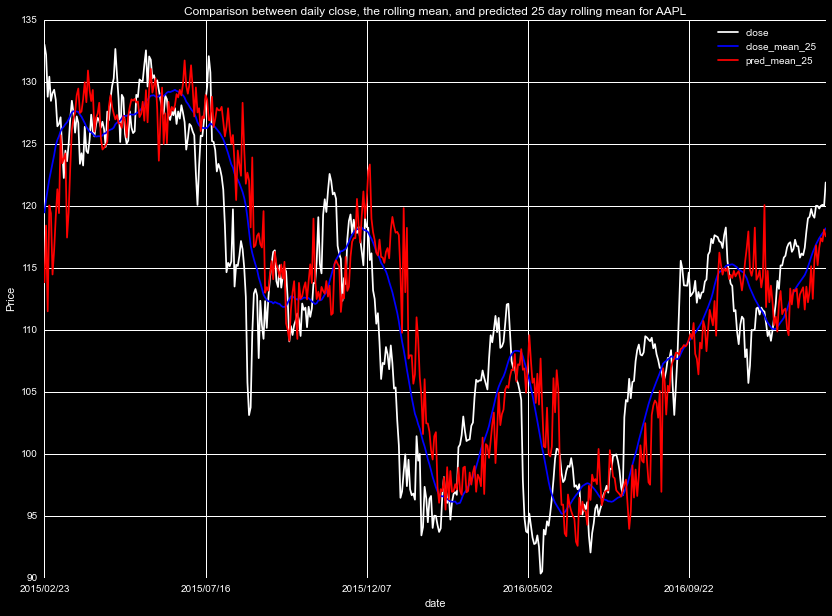

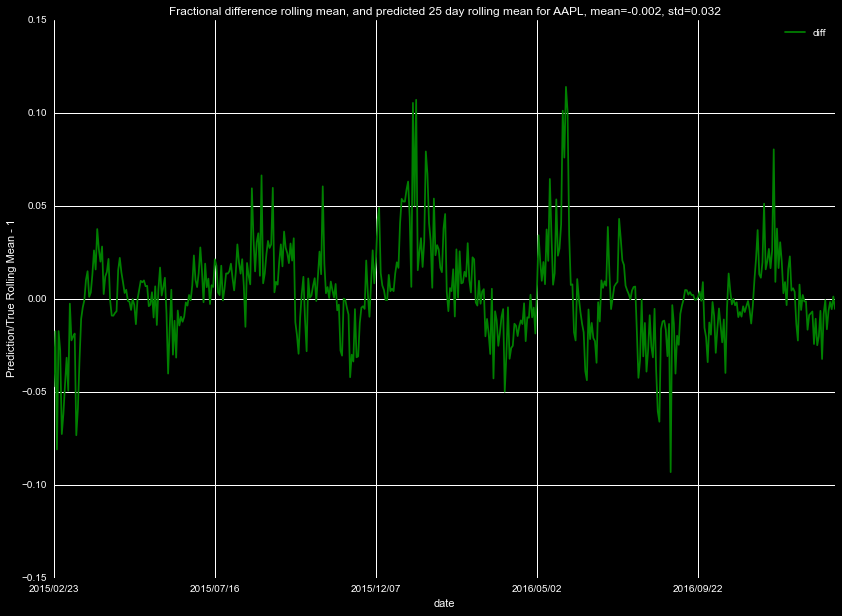

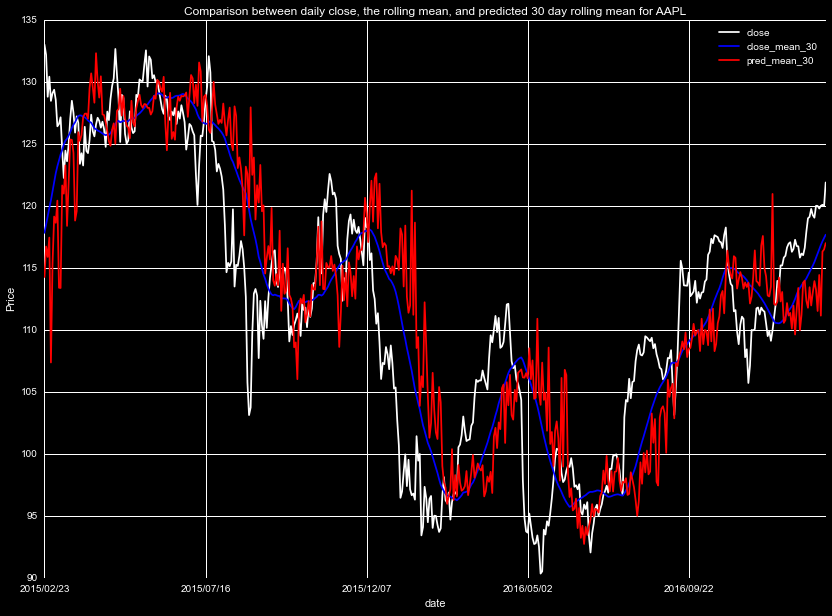

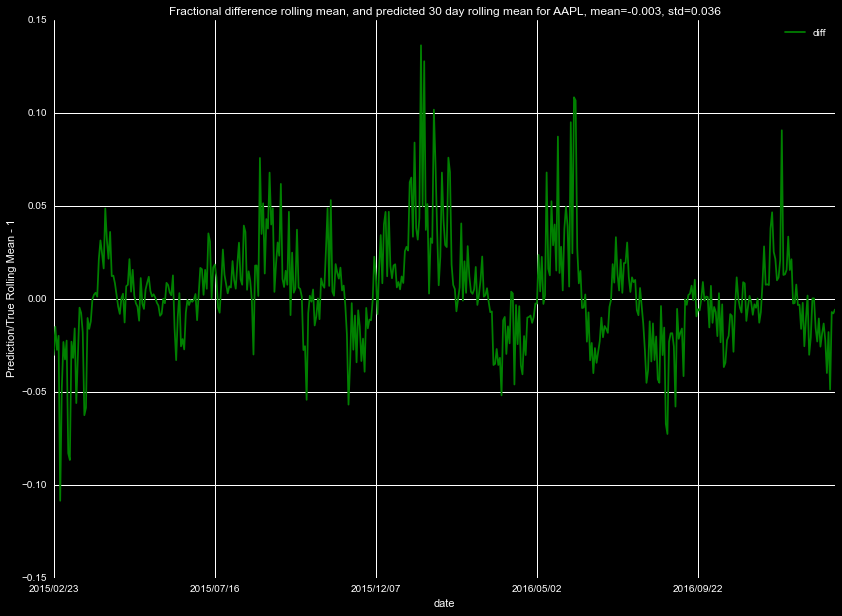

In [260]:
max_ind = close_df.shape[0]
low = int( 0.0*max_ind )
hi  = int( 0.2*max_ind )
for i in roll_nums:
    my_ax = plt.gca()
    close_df[hi:low:-1].plot( y = 'close'             , color='w', ax=my_ax )
    close_df[hi:low:-1].plot( y = 'close_mean_'+str(i), color='b', ax=my_ax )
    close_df[hi:low:-1].plot( y =  'pred_mean_'+str(i), color='r', ax=my_ax )
    plt.title( 'Comparison between daily close, the rolling mean, and predicted ' + str(i) + ' day rolling mean for AAPL' )
    plt.ylabel( 'Price' )
    plt.show()
    
    my_ax = plt.gca()
    close_df['diff'] = close_df['pred_mean_'+str(i)] / close_df['close_mean_'+str(i)] - 1.
    close_df[hi:low:-1].plot( y='diff', color='g', ax=my_ax )
    plt.title( 'Fractional difference rolling mean, and predicted ' + str(i) + 
               ' day rolling mean for AAPL, mean=%5.3f, std=%5.3f'%(close_df['diff'].mean(),close_df['diff'].std()) )
    plt.ylabel( 'Prediction/True Rolling Mean - 1' )
    plt.ylim( [-0.15,0.15] )
    plt.show()

In [68]:
# Some values noisy, lets test the trend in rolling means

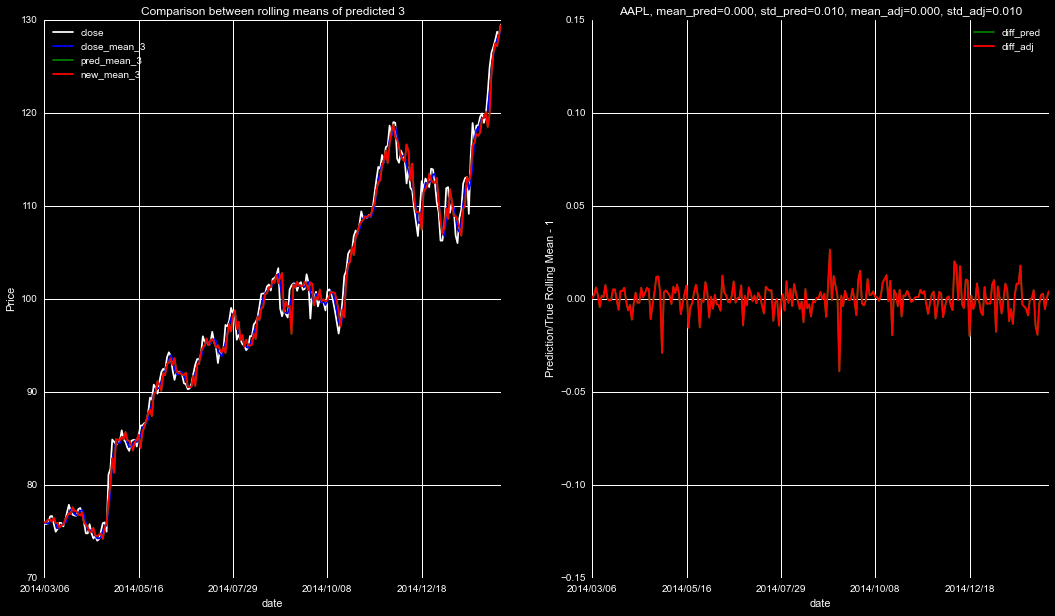

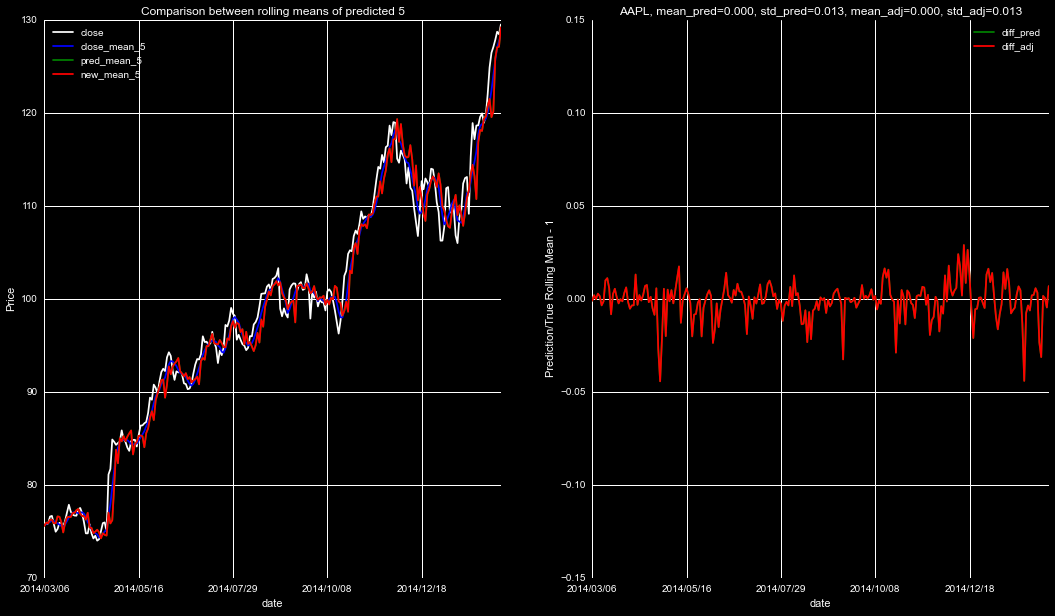

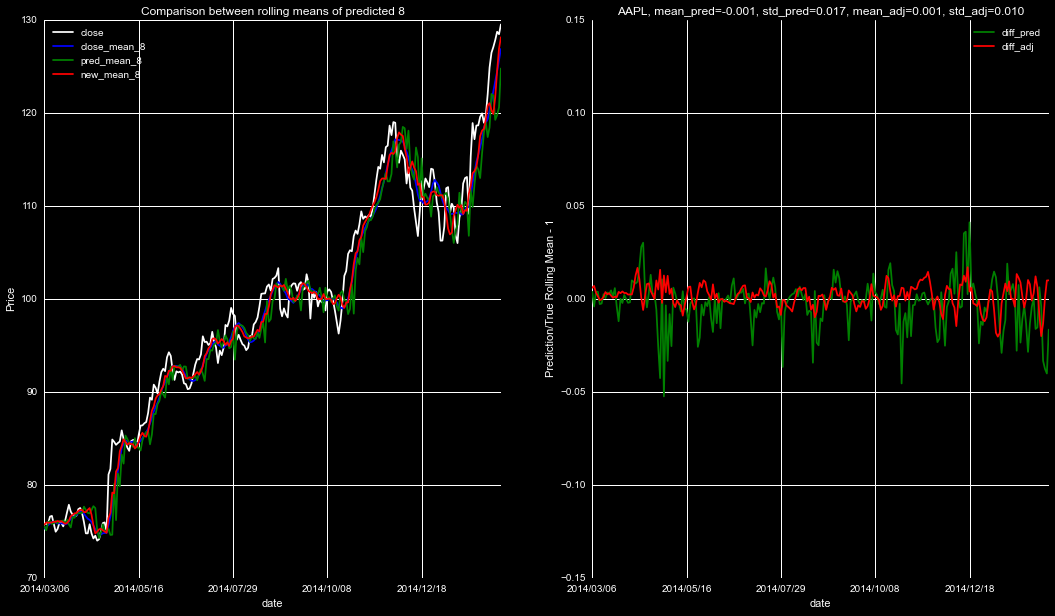

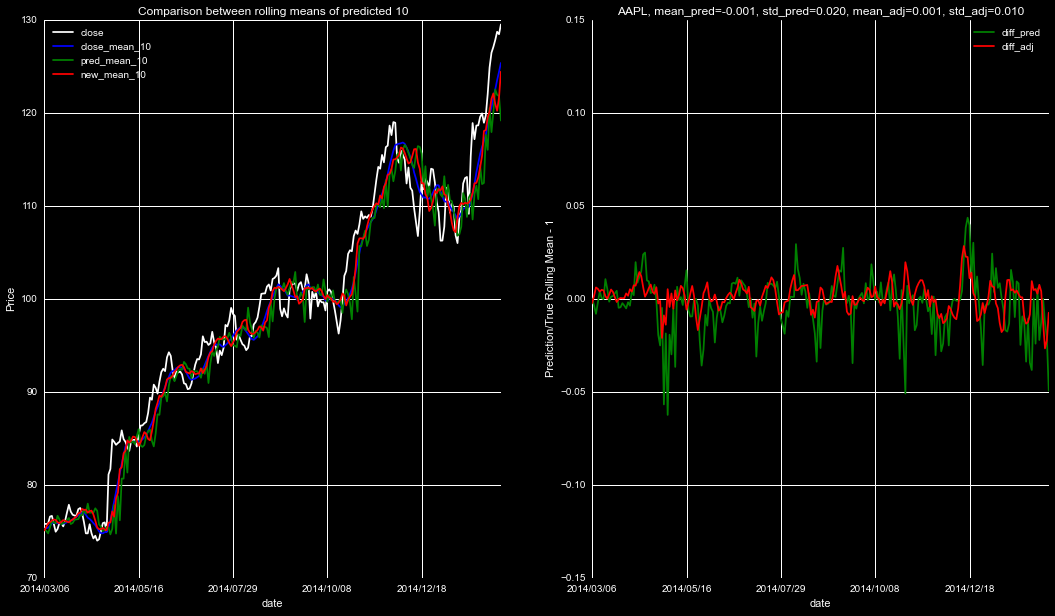

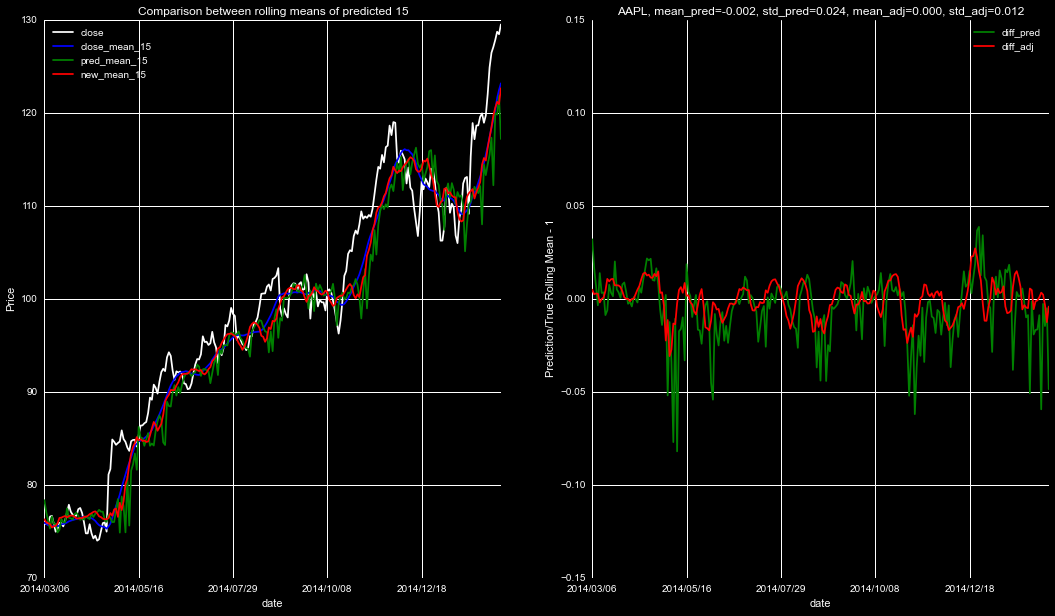

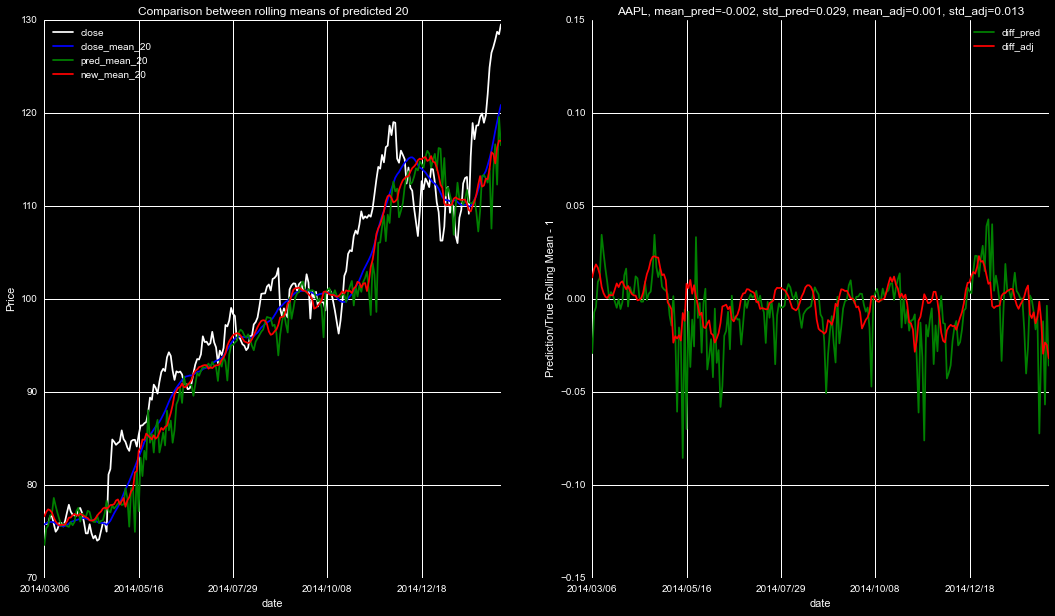

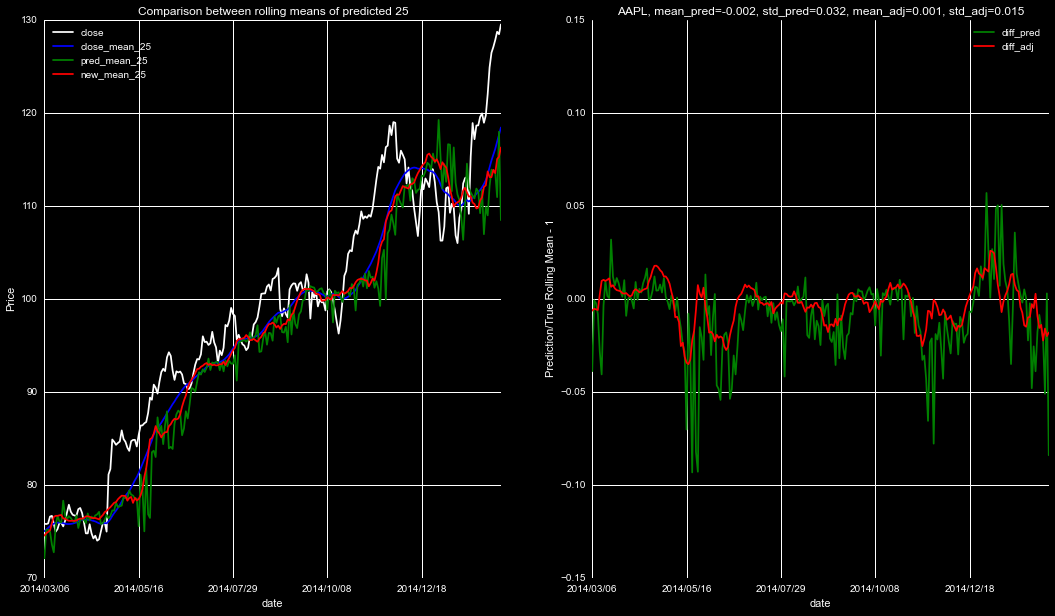

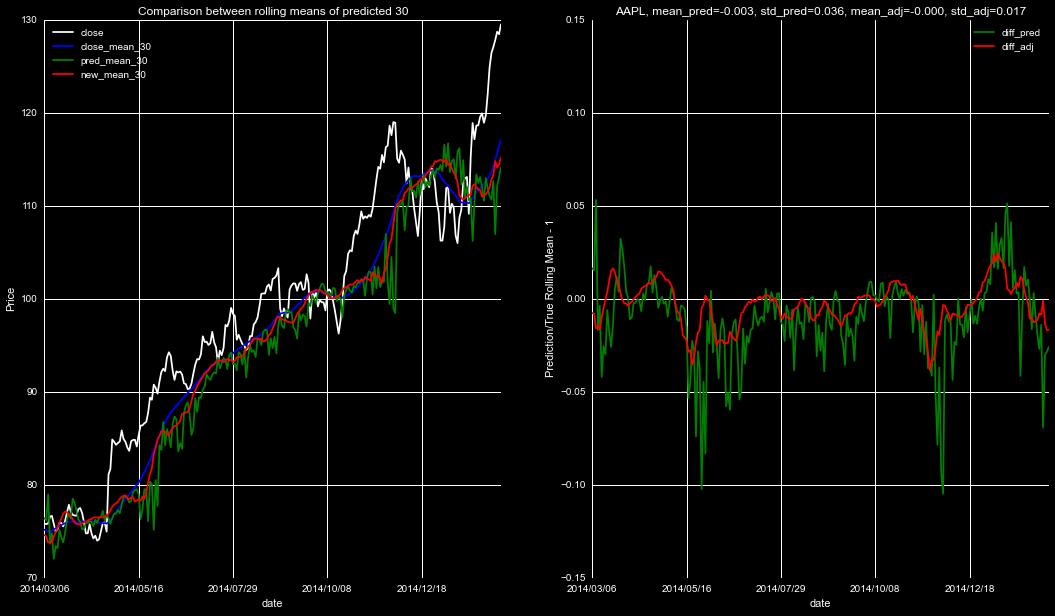

In [293]:
max_ind = close_df.shape[0]
low = int( 0.2*max_ind )
hi  = int( 0.3*max_ind )
for i in roll_nums:

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,10) )

    close_df[hi:low:-1].plot( y = 'close'             , color='w', ax=ax1 )
    close_df[hi:low:-1].plot( y = 'close_mean_'+str(i), color='b', ax=ax1 )
    close_df[hi:low:-1].plot( y =  'pred_mean_'+str(i), color='g', ax=ax1 )
    close_df[hi:low:-1].plot( y =   'new_mean_'+str(i), color='r', ax=ax1 )    
    ax1.set_title( 'Comparison between rolling means of predicted ' + str(i)) #+ ' day rolling mean for AAPL' )
    ax1.set_ylabel( 'Price' )
    
    close_df['diff_pred'] = close_df['pred_mean_'+str(i)] / close_df['close_mean_'+str(i)] - 1.
    close_df['diff_adj' ] = close_df[ 'new_mean_'+str(i)] / close_df['close_mean_'+str(i)] - 1.
    
    close_df[hi:low:-1].plot( y='diff_pred', color='g', ax=ax2 )
    close_df[hi:low:-1].plot( y='diff_adj' , color='r', ax=ax2 )
    
    ax2.set_title( 'AAPL, mean_pred=%5.3f, std_pred=%5.3f, mean_adj=%5.3f, std_adj=%5.3f'%(
                   close_df['diff_pred'].mean(),close_df['diff_pred'].std(),
                   close_df['diff_adj' ].mean(),close_df['diff_adj' ].std(),
               ) )
    ax2.set_ylabel( 'Prediction/True Rolling Mean - 1' )
    ax2.set_ylim( [-0.15,0.15] )
    plt.show()

In [301]:
close_df.head(30)

,close,close_mean_3,close_mean_5,close_mean_8,close_mean_10,close_mean_15,close_mean_20,close_mean_25,close_mean_30,pred_mean_3,pred_mean_5,pred_mean_8,pred_mean_10,pred_mean_15,pred_mean_20,pred_mean_25,pred_mean_30
date,,,,,,,,,,,,,,,,,
2017/01/26,121.94,121.263333,120.774,120.45500,120.193,119.620000,118.7890,118.3944,117.955667,120.408421,121.074918,NaN,NaN,NaN,NaN,NaN,NaN
2017/01/25,121.88,120.643333,120.342,120.09250,119.974,119.225333,118.5550,118.1824,117.667667,120.875997,120.448427,NaN,NaN,NaN,NaN,NaN,NaN
2017/01/24,119.97,120.016667,119.964,119.76375,119.697,118.843333,118.2870,117.9460,117.403333,120.606128,120.237282,NaN,NaN,NaN,NaN,NaN,NaN
2017/01/23,120.08,119.953333,119.970,119.73625,119.599,118.566667,118.1030,117.7800,117.141667,120.305391,119.745644,120.332325,120.029964,NaN,NaN,NaN,NaN
2017/01/20,120.00,119.923333,119.762,119.61500,119.382,118.343333,117.9520,117.5844,116.840000,120.130340,119.339763,119.982734,119.865542,117.480109,NaN,NaN,NaN
2017/01/19,119.78,119.923333,119.612,119.48875,119.043,118.127333,117.7995,117.3920,116.505000,119.982925,119.712295,119.710493,119.057734,117.062522,116.686418,NaN,NaN
2017/01/18,119.99,119.676667,119.606,119.25500,118.667,117.959333,117.6425,117.1328,116.149333,119.624635,119.660125,119.619286,118.737339,117.319345,116.851972,117.505107,NaN
2017/01/17,120.00,119.430000,119.430,118.83250,118.283,117.728000,117.4415,116.8912,115.813000,119.731869,119.243771,119.145392,117.510269,117.406957,116.934266,116.995242,114.958207
2017/01/13,119.04,119.346667,119.228,118.33500,117.865,117.480667,117.2325,116.5760,115.462667,119.745730,118.846403,118.830667,116.630228,117.348582,117.138847,116.874233,114.298699


In [303]:
foo = fv.pred_from_mean( close_df, roll_nums )
foo = foo[['close',
           'pred_3_day_1', 'pred_3_day_2', 'pred_3_day_3',
           'pred_5_day_1', 'pred_5_day_2',
           'pred_8_day_1', 'pred_8_day_2', 'pred_8_day_3',
           'pred_10_day_1', 'pred_10_day_2',
           'pred_15_day_1', 'pred_15_day_2', 'pred_15_day_3', 'pred_15_day_4', 'pred_15_day_5',
           'pred_20_day_1', 'pred_20_day_2', 'pred_20_day_3', 'pred_20_day_4', 'pred_20_day_5',
           'pred_25_day_1', 'pred_25_day_2', 'pred_25_day_3', 'pred_25_day_4', 'pred_25_day_5',
           'pred_30_day_1', 'pred_30_day_2', 'pred_30_day_3', 'pred_30_day_4', 'pred_30_day_5'
          ]]
foo = foo.dropna()

In [307]:
foo.head(20)

,close,pred_3_day_1,pred_3_day_2,pred_3_day_3,pred_5_day_1,pred_5_day_2,pred_8_day_1,pred_8_day_2,pred_8_day_3,pred_10_day_1,...,pred_25_day_1,pred_25_day_2,pred_25_day_3,pred_25_day_4,pred_25_day_5,pred_30_day_1,pred_30_day_2,pred_30_day_3,pred_30_day_4,pred_30_day_5
date,,,,,,,,,,,,,,,,,,,,,
2017/01/17,120.00,120.00,119.731869,119.463739,119.487820,118.999721,119.234624,118.981427,118.728231,118.245848,...,116.205373,116.722259,117.239145,117.756032,118.272918,112.252702,108.512870,104.773037,101.033205,97.293372
2017/01/13,119.04,119.04,119.745730,120.451461,119.296067,118.396739,119.050254,118.804441,118.558628,117.717334,...,116.232096,116.023937,115.815779,115.607621,115.399463,110.057879,105.739454,101.421029,97.102603,92.784178
2017/01/12,119.25,119.25,119.132600,119.015199,118.525368,117.310905,118.256769,117.988171,117.719572,116.850650,...,115.711775,114.853416,113.995056,113.136697,112.278338,108.734518,104.789114,100.843710,96.898306,92.952902
2017/01/11,119.75,119.75,119.216877,118.683755,118.263877,116.357877,117.698100,117.132322,116.566544,116.565794,...,113.849013,112.431248,111.013483,109.595719,108.177954,107.299442,104.513912,101.728381,98.942850,96.157319
2017/01/10,119.11,119.11,117.568421,116.026841,116.783482,115.213604,117.676711,118.569941,119.463171,117.689669,...,113.335132,111.462704,109.590276,107.717849,105.845421,105.706801,102.794194,99.881587,96.968981,94.056374
2017/01/09,118.99,118.99,117.275250,115.560500,117.164026,116.941578,117.167003,117.169979,117.172955,117.192516,...,111.716192,110.121689,108.527185,106.932681,105.338178,107.019958,105.889537,104.759117,103.628697,102.498276
2017/01/06,117.91,117.91,115.796959,113.683918,116.271862,117.221669,116.894450,117.517037,118.139624,117.280158,...,110.589096,108.727179,106.865262,105.003345,103.141427,106.114008,105.550568,104.987128,104.423688,103.860247
2017/01/05,116.61,116.61,116.340545,116.071089,116.536830,116.929399,116.859655,117.182481,117.505307,116.961989,...,109.519712,107.463675,105.407638,103.351601,101.295564,106.635660,107.556676,108.477692,109.398709,110.319725
2017/01/04,116.02,116.02,116.179005,116.338010,116.789030,118.009081,116.260918,115.732806,115.204694,116.163445,...,107.751967,106.748611,105.745254,104.741898,103.738541,108.424112,110.433256,112.442400,114.451543,116.460687


[ 111.59  109.83  108.84  110.41  111.06  110.88  107.79  108.43  105.71
  107.11  109.99  109.95  110.06  111.73  111.8   111.23  111.79  111.57
  111.46  110.52  109.49  109.9   109.11  109.95  111.03  112.12  113.95
  113.3   115.19  115.19] [ 111.59        114.11452973  116.63905945  113.49353545  112.25154688
  115.20773587  116.9219363   118.63613672  117.02552039  117.23268857
  114.79695831  114.23981779  113.68267727  113.12553676  112.56839624
  114.34224062  114.83691312  115.33158563  115.82625813  116.32093064
  112.65148654  110.64141222  108.6313379   106.62126358  104.61118926
  109.61238543  110.34817107  111.08395672  111.81974237  112.55552802]


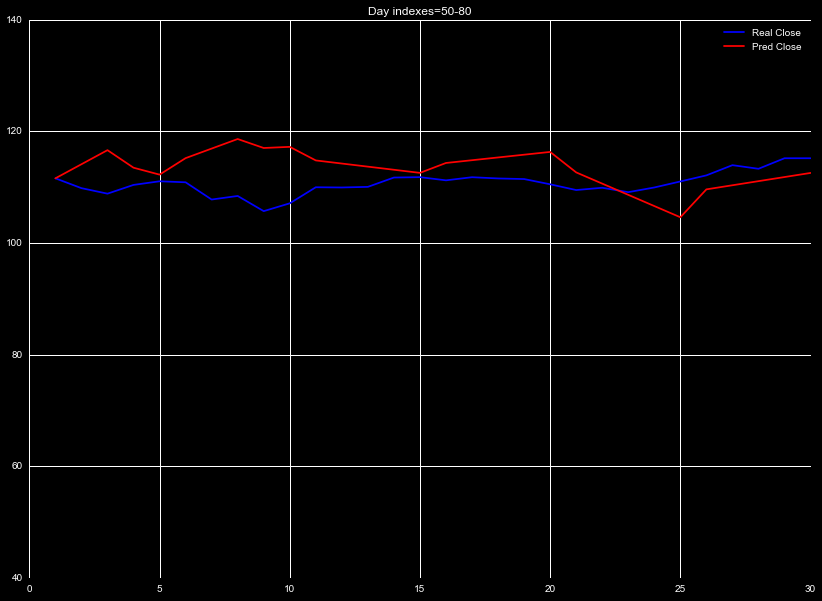

[ 113.55  114.62  112.71  112.88  113.09  113.95  112.18  113.05  112.52
  113.    113.05  113.89  114.06  116.05  116.3   117.34  116.98  117.63
  117.55  117.47  117.12  117.06  116.6   117.65  118.25  115.59  114.48
  113.72  113.54  111.49] [ 113.55        113.74785971  113.94571942  114.10213822  114.81069524
  112.02927352  109.95640882  107.88354413  110.30088992  110.98985213
  107.77795576  107.14722222  106.51648868  105.88575514  105.25502159
  106.87912645  107.15110478  107.42308311  107.69506144  107.96703977
  108.49476519  109.29852675  110.10228831  110.90604986  111.70981142
  110.61531166  111.00007918  111.3848467   111.76961421  112.15438173]


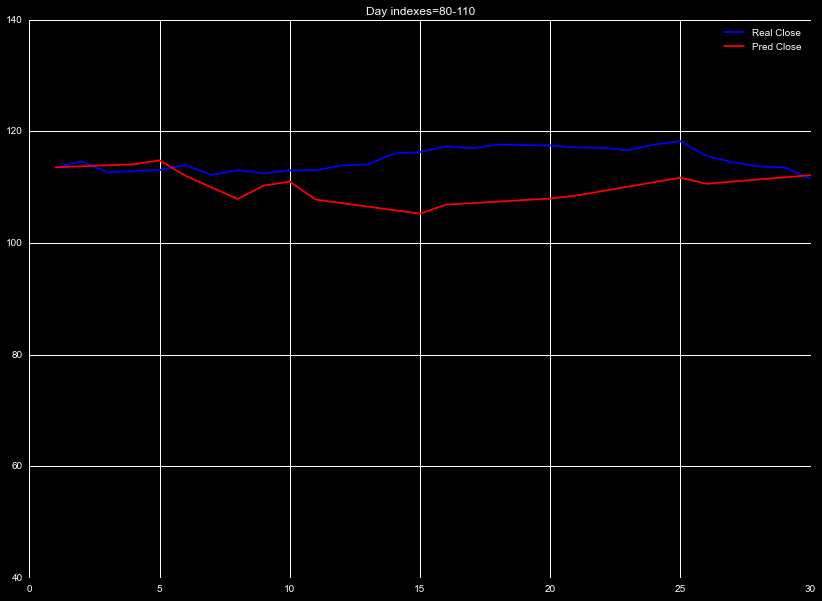

[  96.67  102.95  104.34  104.21  106.05  104.48  105.79  105.87  107.48
  108.37  108.81  108.    107.93  108.18  109.48  109.38  109.22  109.08
  109.36  108.51  108.85  108.03  107.57  106.94  106.82  106.    106.1
  106.73  107.73  107.7 ] [  96.67         99.10620292  101.54240583   99.42226414  100.05438658
  100.33108689  101.23990965  102.1487324   100.35331416   98.5801232
   98.84172929   98.46383307   98.08593685   97.70804063   97.33014441
   96.6979958    95.65704002   94.61608423   93.57512845   92.53417266
   93.36768536   92.4313862    91.49508704   90.55878789   89.62248873
   95.77906591   98.99205007  102.20503422  105.41801837  108.63100253]


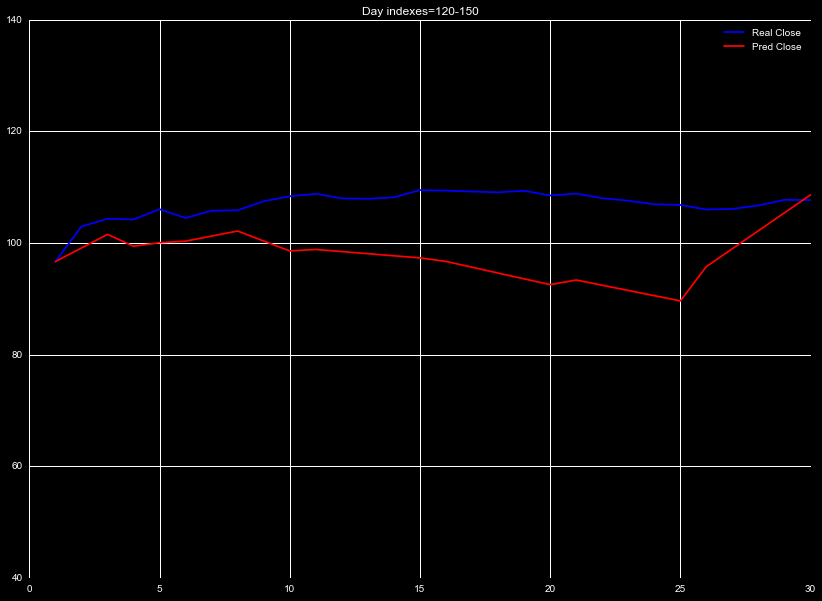

[ 97.34  97.46  97.14  97.55  95.33  95.1   95.91  95.55  96.1   93.4
  92.04  93.59  94.4   95.6   95.89  94.99  95.53  95.94  96.68  96.98
  97.42  96.87  98.79  98.78  99.83  99.87  99.96  99.43  98.66  97.34] [  97.34         99.81934865  102.2986973    99.3068381    98.28181701
   98.89705923   98.48728037   98.0775015    98.50130608   98.52935751
   98.92158897   99.02665969   99.13173041   99.23680114   99.34187186
   94.40127589   90.85343501   87.30559412   83.75775323   80.20991234
   88.53597472   89.45876018   90.38154563   91.30433108   92.22711654
   91.06927218   91.5850671    92.10086201   92.61665692   93.13245184]


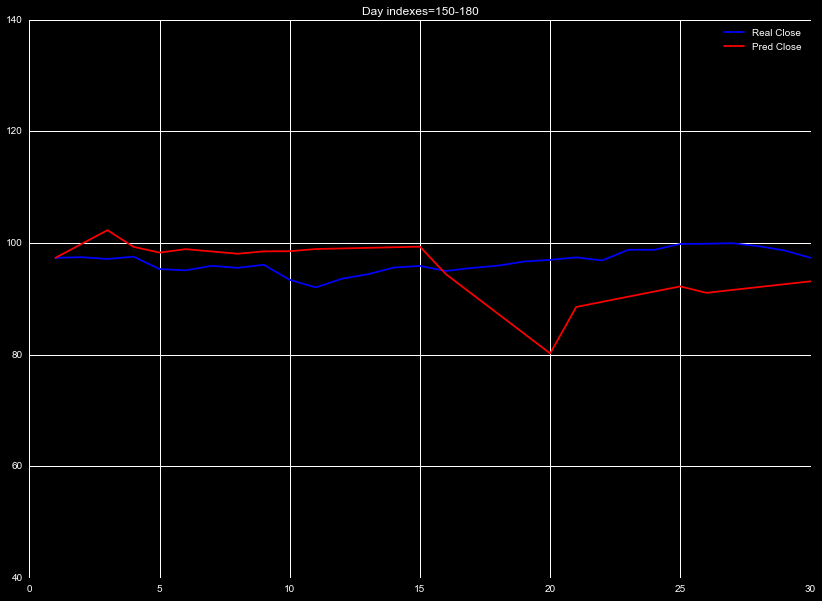

[  93.74   93.64   95.18   94.19   93.24   92.72   92.79   93.42   92.51
   90.34   90.52   93.88   93.49   94.56   94.2    95.22   96.43   97.9
   99.62  100.41  100.35   99.86   98.46   97.72   97.92   98.63   99.03
   98.94   99.65   98.83] [  93.74         94.07571227   94.41142454   99.5297834   110.43792566
  100.80811661  102.08644981  103.36478302  101.78401725  101.17915213
  107.71847371  109.20208782  110.68570194  112.16931605  113.65293017
  109.856793    109.2351113   108.6134296   107.9917479   107.3700662
  109.58790779  110.31876644  111.04962508  111.78048373  112.51134237
  109.75988011  108.79257138  107.82526265  106.85795392  105.89064519]


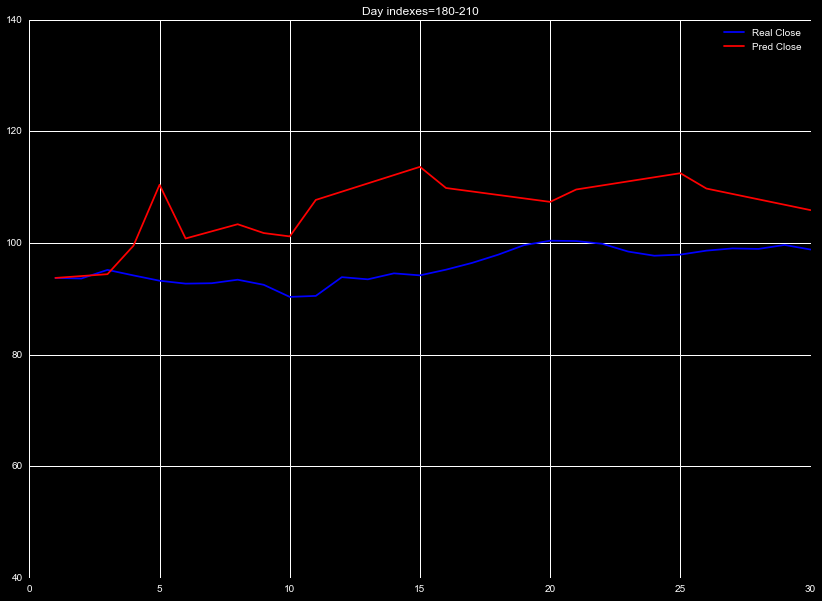

[ 105.8   105.92  105.91  106.72  106.13  105.67  105.19  107.68  109.56
  108.99  109.99  111.12  109.81  110.96  108.54  108.66  109.02  110.44
  112.04  112.1   109.85  107.48  106.91  107.13  105.97  105.68  105.08
  104.35   97.82   94.83] [ 105.8         105.66486087  105.52972173  104.86487341  103.26489851
  104.32551267  103.78615192  103.24679117  103.35349851  102.48819169
  100.37279162   99.6276149    98.88243818   98.13726145   97.39208473
   96.83998793   95.30815025   93.77631256   92.24447488   90.71263719
   95.1637398    96.20431022   97.24488064   98.28545107   99.32602149
   95.25257434   93.75834461   92.26411487   90.76988514   89.27565541]


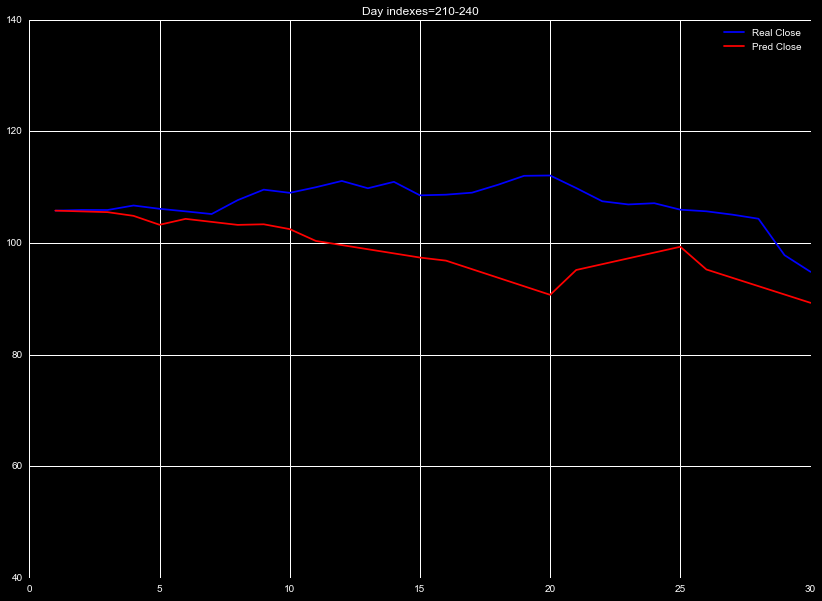

[  96.35   96.6    94.02   95.01   94.99   94.27   93.7    93.99   96.64
   98.12   96.26   96.04   96.88   94.69   96.1    96.76   96.91   96.69
  100.53  100.75  101.5   103.01  101.87  101.03  101.12  101.17  102.26
  102.52  104.58  105.97] [  96.35         97.47022541   98.59045083   96.90611868   95.77790522
   97.5610732    98.21602771   98.87098223   98.37741112   98.70017793
   96.47651232   96.00128762   95.52606291   95.05083821   94.57561351
   95.49545999   95.4725078    95.4495556    95.42660341   95.40365121
  100.84579021  104.89296617  108.94014212  112.98731808  117.03449404
  115.11554005  119.74708849  124.37863693  129.01018538  133.64173382]


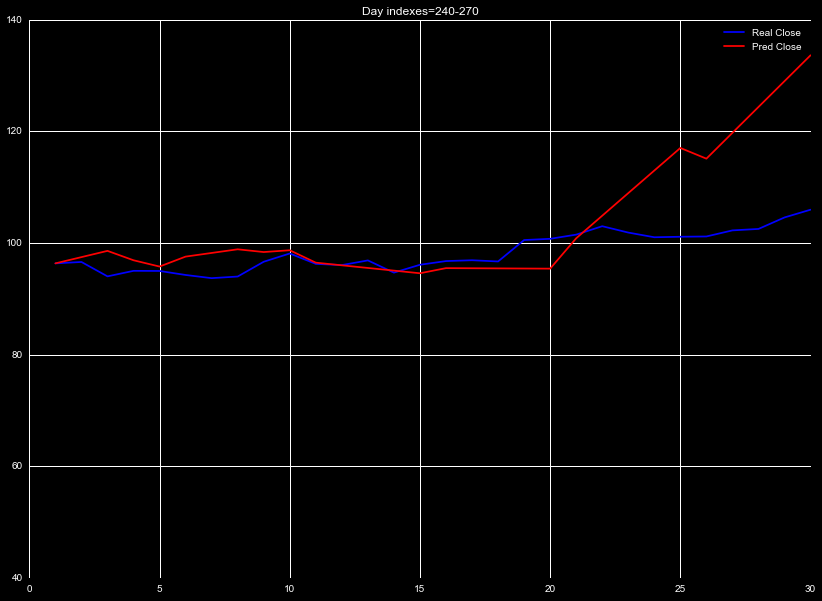

In [306]:
day_list = [ 50, 80, 120, 150, 180, 210, 240 ]

day_len = 30

pred_days = range(1,31)#[1,2,3,4,5,6,7,8,9,10,11,13,15,16,18,20,21,23,25,26,28,30]

# Get the real values of the quotes
real_values = []
for i in day_list:
    real_values.append( foo['close'].values[ i:i-day_len:-1 ] )
    
    
# Get predicted values 
pred_values = []
for i in day_list:
    pred_values.append( foo.drop( 'close', axis=1 ).values[ i, 0:len(pred_days) ] )
    
    

# Plot the results
for i in range( 0, len( day_list) ):
    print real_values[i], pred_values[i]
    plt.plot( range( 1, day_len+1 ), real_values[i], color='b', label='Real Close' )
    plt.plot(           pred_days  , pred_values[i], color='r', label='Pred Close' )
    plt.ylim( [40, 140] )
    plt.title( 'Day indexes=%i-%i'%(day_list[i], day_list[i]+30) )
    plt.legend()
    plt.show()